In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import igraph                                      # core
import numpy as np                                 # core

from sklearn.linear_model import LinearRegression  # fit power law and exp function
from tqdm import tqdm_notebook as tqdm             # display progress of calculations 
from tabulate import tabulate                      # nice formatting in table-like structure

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator          # use to enforce integer ticks 

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset  
from matplotlib.pyplot import setp                 # this and prior is for enlarging (zooming) part of the plot
%matplotlib inline

In [3]:
import random
random.seed(42)
np.random.seed(42) # set random generator seeds for reproduceability

# https://github.com/igraph/igraph/issues/512
from igraph import arpack_options
arpack_options.maxiter=300000 # mitigate random arpack fall-offs on single-omponent graphs 

# Network Science: course project

### Author: Kostiantyn Lapchevskyi

# 1. Introduction

In this work I focus on susceptability of provided Power grid network's structure to directed attacks. 

Power (transformation) stations assumed to be nodes, high-voltage power lines - links.

Assumption: connected component of network ceise to exist if it is less than 10% of original network's size.   

In [4]:
power_graph = igraph.Graph.Read_Edgelist('power.txt', directed=False)
power_nodes_count = power_graph.vcount()
power_links_count = power_graph.ecount()
print("Number of nodes: ", power_nodes_count)
print("Number of links: ", power_links_count)

Number of nodes:  4941
Number of links:  6594


# 2. Reference network: Barabasi-Albert

As a reference network I use the one generated from Barabasi-Albert (preferential attachement) model with excessive links removed. 

Removal strategy: 

1. Randomly select a node
2. Find an edge connected to the node
3. Remove the edge
4. If that parts network (number of connected components > 1), then rollback 
5. If number of links matches the one of power grid network then done, otherwise go to step 1 

I considered also "regular rectangular lattice" and "small-world" models, yet "Barabasi-Albert" suits the task better as it more closely represents the structure of the power grid network (e.g.: degree distribution). In all cases, aforementioned procedure of links removal has been applied - keep number of potential objectives to take down the same for fair comparison. For the same reason graph is enforced to be connected, otherwise some components may be smaller than threshold from the very start, making it effectively smaller.  

Small visual example of reference network structure (n=10, m=2, power=1)

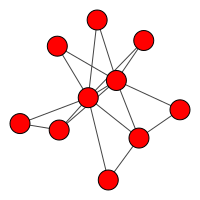

In [5]:
t = igraph.Graph.Barabasi(n=10,m=2)
t_layout = t.layout_fruchterman_reingold()

igraph.plot(t, layout=t_layout, bbox=(0,0,200,200))

In [6]:
n = power_nodes_count
m = 2
power = 0.3

In [7]:
print("Parameters of reference network")
print(tabulate([["n", n], ["m", m], ["power", 0.3]], headers=["Name", "Value"]))

Parameters of reference network
Name      Value
------  -------
n        4941
m           2
power       0.3


In [8]:
ref_graph = igraph.Graph.Barabasi(n,m,power=power)
while len(ref_graph.components()) != 1:
    # enforce fully connected construction
    ref_graph = igraph.Graph.Barabasi(n,m,power=power) 
while ref_graph.ecount() > power_links_count:
    # remove excessive links, but keep construction fully connected
    ref_anchor_node_idx = np.random.randint(ref_graph.vcount())
    for edge in ref_graph.es:
        if edge.source == ref_anchor_node_idx or edge.target == ref_anchor_node_idx:
            ref_link_delete = edge.index
            break
    
    tmp_graph = ref_graph.copy()
    tmp_graph.delete_edges(ref_link_delete)
    if len(tmp_graph.components()) == 1:
        ref_graph = tmp_graph

In [9]:
ref_nodes_count = ref_graph.vcount()
ref_links_count = ref_graph.ecount()
print("Number of nodes: ", ref_nodes_count)
print("Number of links: ", ref_links_count)

Number of nodes:  4941
Number of links:  6594


# 3. Global characteristics 

In [10]:
# links density
power_links_density = 2*power_links_count/(power_nodes_count*(power_nodes_count-1))
ref_links_density = 2*ref_links_count/(ref_nodes_count*(ref_nodes_count-1))

# degree (mean, min, max)
power_graph_degrees = np.array(power_graph.degree()) # number of adjacent edges
ref_graph_degrees = np.array(ref_graph.degree())

### Shortest path handling block
power_graph_shortest_paths = np.array(power_graph.shortest_paths(), dtype=np.float32)
power_graph_not_all_nodes_reachable = np.any(power_graph_shortest_paths == np.inf)
if power_graph_not_all_nodes_reachable:
    power_graph_shortest_paths[power_graph_shortest_paths==np.inf] = np.nan
#print("Power grid network:", "Nodes form disjoint clusters, infinite distances excluded" if power_graph_not_all_nodes_reachable else "All nodes are reachable from each other")
np.fill_diagonal(power_graph_shortest_paths, val=np.nan) # exclude distance from the node to itself 

ref_graph_shortest_paths = np.array(ref_graph.shortest_paths(), dtype=np.float32)
ref_graph_not_all_nodes_reachable = np.any(ref_graph_shortest_paths == np.inf)
if ref_graph_not_all_nodes_reachable:
    ref_graph_shortest_paths[ref_graph_shortest_paths==np.inf] = np.nan
#print("Reference network:", "Nodes form disjoint clusters, infinite distances excluded" if ref_graph_not_all_nodes_reachable else "All nodes are reachable from each other")
np.fill_diagonal(ref_graph_shortest_paths, val=np.nan) # exclude distance from the node to itself 
### Shortest path handling block: end

# shortest path length (mean)
power_graph_mean_shortest_path = np.nanmean(power_graph_shortest_paths)
ref_graph_mean_shortest_path = np.nanmean(ref_graph_shortest_paths)

# diameter
power_graph_diameter = power_graph.diameter() # max shortest path
ref_graph_diameter = ref_graph.diameter()     # diameter of the largest connected component

# Number of connected components
power_graph_connected_components = power_graph.components()
ref_graph_connected_components = ref_graph.components()
power_graph_connected_components_count = len(power_graph_connected_components)
ref_graph_connected_components_count = len(ref_graph_connected_components)

# GCC size 
power_graph_greatest_connected_component_size = np.max([len(component) for component in power_graph_connected_components])
ref_graph_greatest_connected_component_size = np.max([len(component) for component in ref_graph_connected_components])

# Clustering coefficient (mean), Global transitivity
# Note: in all cases, if vertex has degree < 2, it yields nan and excluded from calculations
power_graph_global_transitivity = power_graph.transitivity_undirected() # global transitivity: number of closed triplets / (number of closed tripplets + number of open triplets)
power_graph_avg_clustering_coef = power_graph.transitivity_avglocal_undirected() # average clustering coefficient: same as previos, but calculated separately for each vertex and then averaged by vertices
ref_graph_global_transitivity   = ref_graph.transitivity_undirected()
ref_graph_avg_clustering_coef   = ref_graph.transitivity_avglocal_undirected() 

# Assortativity (based on degree)
# = Pearson correlation coefficient of degree between pairs of linked nodes
power_graph_assortativity = power_graph.assortativity_degree() 
ref_graph_assortativity = ref_graph.assortativity_degree()

# Clique number
power_graph_clique_number = power_graph.clique_number() # number of nodes in the biggest complete subgraph (each node connected to each other)
ref_graph_clique_number = ref_graph.clique_number()

In [11]:
print(tabulate([["Nodes", power_nodes_count, ref_nodes_count], 
                ["Links", power_links_count, ref_links_count], 
                ["Density of links", np.round(power_links_density,5), np.round(ref_links_density,5)], 
                ["Node degree (avg.)", np.round(power_graph_degrees.mean(),3), np.round(ref_graph_degrees.mean(),3)], 
                ["Node degree (min.)", power_graph_degrees.min(), ref_graph_degrees.min()], 
                ["Node degree (max.)", power_graph_degrees.max(), ref_graph_degrees.max()], 
                ["Shortest path length (avg.)", np.round(power_graph_mean_shortest_path,2), np.round(ref_graph_mean_shortest_path,2)], 
                ["Diameter", power_graph_diameter, ref_graph_diameter], 
                ["Number of connected components", power_graph_connected_components_count, ref_graph_connected_components_count], 
                ["GCC size", power_graph_greatest_connected_component_size, ref_graph_greatest_connected_component_size], 
                ["GCC relative size, %", np.round(100*power_graph_greatest_connected_component_size/power_nodes_count,1), np.round(100*ref_graph_greatest_connected_component_size/ref_nodes_count,1)], 
                ["Clustering coefficient (avg.)", np.round(power_graph_avg_clustering_coef,4), np.round(ref_graph_avg_clustering_coef,4)], 
                ["Global transitivity", np.round(power_graph_global_transitivity,4), np.round(ref_graph_global_transitivity,4)], 
                ["Assortativity", np.round(power_graph_assortativity,4), np.round(ref_graph_assortativity,4)], 
                ["Clique number", power_graph_clique_number, ref_graph_clique_number]], 
               headers=["Characteristic", "Power grid network", "Reference network"]))

Characteristic                    Power grid network    Reference network
------------------------------  --------------------  -------------------
Nodes                                     4941                 4941
Links                                     6594                 6594
Density of links                             0.00054              0.00054
Node degree (avg.)                           2.669                2.669
Node degree (min.)                           1                    1
Node degree (max.)                          19                   21
Shortest path length (avg.)                 18.99                 7.72
Diameter                                    46                   18
Number of connected components               1                    1
GCC size                                  4941                 4941
GCC relative size, %                       100                  100
Clustering coefficient (avg.)                0.1065               0.0006
Global transitivit

**Key differences**:

1. Distances on power grid network are higher. Expectable though as it is affected by geographical distances (unfeasible to connect directly far apart stations), while no such limitation on reference network. 
2. Clustering coefficient (and transitivity) is much higher for power grid network. In conjunction with prior statement, it suggests that it is more likely for power grid to have "small local loops" (closed triplets), while reference network tends to have skip-connections forming "large loops" (4+ nodes).
3. Clique number supports that statement, however 6 (4+ in fact) for power grid looks fishy (rather hard and inconvenient to pull off physically in real world). I suspect some proxy-nodes missing from structure definition, but will leave it be as is.  

# 4. Distributions

In [14]:
def util_get_hist_limits(power, ref, density, log=False, power_bins=10, ref_bins=10):
    plt.hist(power, bins=power_bins, density=density, log=log)
    xlim_power = plt.xlim()
    ylim_power = plt.ylim()
    plt.clf()
    plt.hist(ref, bins=ref_bins, density=density, log=log)
    xlim_ref = plt.xlim()
    ylim_ref = plt.ylim()
    plt.clf()

    xlim = (min(xlim_power[0], xlim_ref[0]), max(xlim_power[1], xlim_ref[1]))
    ylim = (min(ylim_power[0], ylim_ref[0]), max(ylim_power[1], ylim_ref[1]))
    
    return xlim, ylim

def util_compare_hist_plot(power, ref, x_unit, y_unit, density, log, integer, power_bins=10, ref_bins=10):
    plt.figure(figsize=(15,8))
    xlim, ylim = util_get_hist_limits(power, ref, density, log, power_bins, ref_bins)

    ax_power = plt.subplot(2,2,1)
    plt.title("Power grid network")
    plt.xlabel(x_unit)
    plt.ylabel(y_unit)
    ax_power.xaxis.set_major_locator(MaxNLocator(integer=integer))
    ax_power.hist(power, bins=power_bins, log=log, density=density)
    plt.xlim(xlim)
    plt.ylim(ylim)

    ax_ref = plt.subplot(2,2,2)
    plt.title("Reference network")
    plt.xlabel(x_unit)
    plt.ylabel(y_unit)
    ax_ref.xaxis.set_major_locator(MaxNLocator(integer=integer))
    ax_ref.hist(ref, bins=ref_bins, log=log, density=density)
    plt.xlim(xlim)
    plt.ylim(ylim);
    
def util_find_fit(x, y, exp):
    """Find parameters that fit specified distribution to data.
    
    Args: 
        x: numpy array of floats
        y: numpy array of floats
        exp: bool, if True - fit y=b*exp[-a*x], otherwise fit y=b*x^[-a]
    
    Return:
        (y_fit, a, b): y_fit are fitted y values, (a, b) - coefficients 
    """
    x = -x if exp else -np.log(x)
    y = np.log(y)
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    a = model.coef_
    b = np.exp(model.intercept_)
    y_fit = np.exp(model.intercept_ + model.coef_ * x)
    return y_fit.reshape(-1), a, b

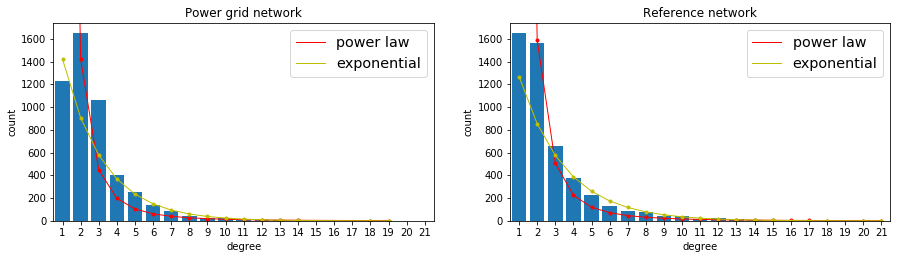

In [15]:
plt.figure(figsize=(15,8))

power_x, power_y = np.unique(power_graph_degrees, return_counts=True)
ref_x, ref_y = np.unique(ref_graph_degrees, return_counts=True)

power_y_fit, power_a, power_b = util_find_fit(power_x, power_y, exp=False)
ref_y_fit, ref_a, ref_b = util_find_fit(ref_x, ref_y, exp=False)

power_y_fit_exp, power_a_exp, power_b_exp = util_find_fit(power_x, power_y, exp=True)
ref_y_fit_exp, ref_a_exp, ref_b_exp = util_find_fit(ref_x, ref_y, exp=True)

xs_tmp = np.concatenate((power_x, ref_x))
ys_tmp = np.concatenate((power_y, ref_y))
xlim = (np.min(xs_tmp) - 0.5, np.max(xs_tmp) + 0.5)
ylim = (np.min(ys_tmp), np.max(ys_tmp)*1.05)

ax_power = plt.subplot(2,2,1)
plt.title("Power grid network")
plt.xlabel("degree")
plt.ylabel("count")
ax_power.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=xlim[1]-xlim[0]))
ax_power.bar(power_x, power_y)
ax_power.plot(power_x, power_y_fit, 'ro', markersize=3)
ax_power.plot(power_x, power_y_fit, 'r', linewidth=1, label="power law")
ax_power.plot(power_x, power_y_fit_exp, 'yo', markersize=3)
ax_power.plot(power_x, power_y_fit_exp, 'y', linewidth=1, label="exponential")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(loc='upper right', fontsize='x-large')

ax_ref = plt.subplot(2,2,2)
plt.title("Reference network")
plt.xlabel("degree")
plt.ylabel("count")
ax_ref.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=xlim[1]-xlim[0]))
ax_ref.bar(ref_x, ref_y)
ax_ref.plot(ref_x, ref_y_fit, 'ro', markersize=3)
ax_ref.plot(ref_x, ref_y_fit, 'r', linewidth=1, label="power law")
ax_ref.plot(ref_x, ref_y_fit_exp, 'yo', markersize=3)
ax_ref.plot(ref_x, ref_y_fit_exp, 'y', linewidth=1, label="exponential")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(loc='upper right', fontsize='x-large');

Power law: $y=bx^{-\frac{1}{a}}$; Exponential: $y=b\exp{[-ax]}$

In [16]:
print(tabulate([[1/power_a, power_b, power_a_exp, power_b_exp], [1/ref_a, ref_b, ref_a_exp, ref_b_exp]], headers=["Power law (a)", "Power law (b)", "Exp (a)", "Exp (b)"]))

  Power law (a)    Power law (b)    Exp (a)    Exp (b)
---------------  ---------------  ---------  ---------
       0.351554          10221.4   0.44995     2229.8
       0.355161          11196.1   0.395547    1885.53


In [17]:
# number of vertices minus one divided by the sum of the lengths of all geodesics from/to the given vertex
power_graph_closeness = np.array(power_graph.closeness())
ref_graph_closeness = np.array(ref_graph.closeness())

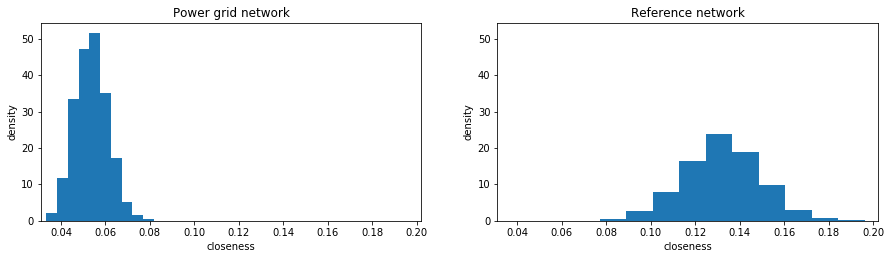

In [18]:
util_compare_hist_plot(power_graph_closeness, ref_graph_closeness, "closeness", "density", density=True, log=False, integer=False)

In [19]:
power_graph_betweenness = power_graph.betweenness()
ref_graph_betweenness = ref_graph.betweenness() # number of shortest paths in graph that pass through the given vertex

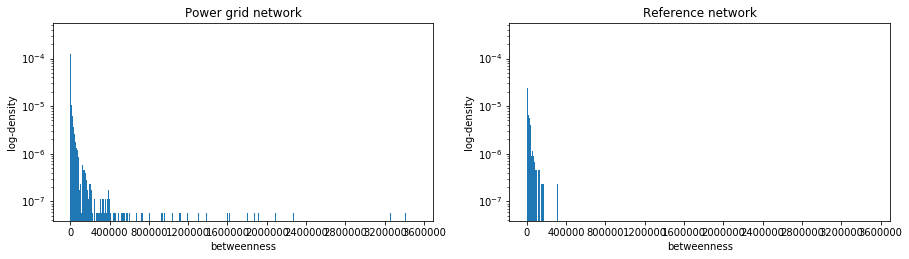

In [20]:
util_compare_hist_plot(power_graph_betweenness, ref_graph_betweenness, "betweenness", "log-density", density=True, log=True, integer=False, power_bins=1000, ref_bins=1000)

In [21]:
power_graph_cliques = power_graph.cliques()
power_graph_cliques_sizes = np.array([len(clique) for clique in power_graph_cliques])
ref_graph_cliques = ref_graph.cliques()
ref_graph_cliques_sizes = np.array([len(clique) for clique in ref_graph_cliques])

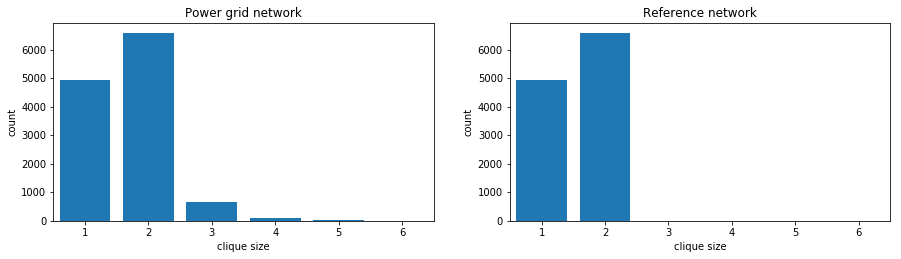

In [22]:
plt.figure(figsize=(15,8))

power_x, power_y = np.unique(power_graph_cliques_sizes, return_counts=True)
ref_x, ref_y = np.unique(ref_graph_cliques_sizes, return_counts=True)

xs_tmp = np.concatenate((power_x, ref_x))
ys_tmp = np.concatenate((power_y, ref_y))
xlim = (np.min(xs_tmp) - 0.5, np.max(xs_tmp) + 0.5)
ylim = (np.min(ys_tmp), np.max(ys_tmp)*1.05)

ax_power = plt.subplot(2,2,1)
plt.title("Power grid network")
plt.xlabel("clique size")
plt.ylabel("count")
ax_power.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_power.bar(power_x, power_y)
plt.xlim(xlim)
plt.ylim(ylim)

ax_ref = plt.subplot(2,2,2)
plt.title("Reference network")
plt.xlabel("clique size")
plt.ylabel("count")
ax_ref.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_ref.bar(ref_x, ref_y)
plt.xlim(xlim)
plt.ylim(ylim);

**Conclusions**:

1. Distribution of degree for power grid network does not exactly follow power-law, neither exponential function, yet we can take power-law fit as "good enough". Lower number of 1-degree nodes than in reference suggests it to be more susceptible to random failures (than reference). 
2. Distribution of closeness shows that not only average, but almost all distances are higher in power grid network. Low variance and absence of distinctive values suggests it to be a less effective criteria for attack.
3. Distribution of betwenness (on contrary) shows prominent candidates for this type of attack, which we would expect from scale-free networks. Candidates for power grid are more distinct than for reference network suggesting it to be more susceptible. In physical world terms, it means some stations serve as large hubs that supply different smaller stations that in turn serve over local region.   

# 5. Correlations

In [23]:
power_graph_local_clustering_coefs = np.array(power_graph.transitivity_local_undirected()) # if degree < 2, then (local) transitivity is nan
power_graph_keep_local_clustering_coefs = ~np.isnan(power_graph_local_clustering_coefs) # skip nan in calculation of correlation

ref_graph_local_clustering_coefs = np.array(ref_graph.transitivity_local_undirected())
ref_graph_keep_local_clustering_coefs = ~np.isnan(ref_graph_local_clustering_coefs)

power_graph_local_clustering_to_degree_corr = np.corrcoef(power_graph_local_clustering_coefs[power_graph_keep_local_clustering_coefs], power_graph_degrees[power_graph_keep_local_clustering_coefs])[0,1]
ref_graph_local_clustering_to_degree_corr = np.corrcoef(ref_graph_local_clustering_coefs[ref_graph_keep_local_clustering_coefs], ref_graph_degrees[ref_graph_keep_local_clustering_coefs])[0,1]
print("Pearson correlation coefficient between local clustering coefficient and node degree")
print("    Power grid network:", np.round(power_graph_local_clustering_to_degree_corr, 4))
print("    Reference network: ", np.round(ref_graph_local_clustering_to_degree_corr, 4))

Pearson correlation coefficient between local clustering coefficient and node degree
    Power grid network: -0.0096
    Reference network:  0.009


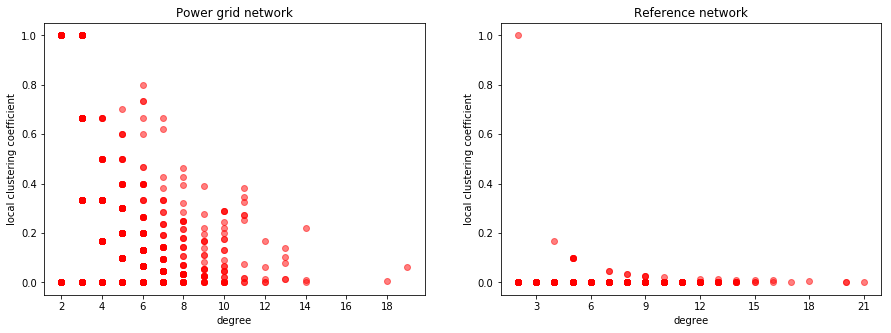

In [ ]:
plt.figure(figsize=(15,5))

ax_power = plt.subplot(1,2,1)
plt.title("Power grid network")
plt.xlabel("degree")
plt.ylabel("local clustering coefficient")
ax_power.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_power.plot(power_graph_degrees[power_graph_keep_local_clustering_coefs], power_graph_local_clustering_coefs[power_graph_keep_local_clustering_coefs], 'ro', alpha=0.5)

ax_ref = plt.subplot(1,2,2)
plt.title("Reference network")
plt.xlabel("degree")
plt.ylabel("local clustering coefficient")
ax_ref.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_ref.plot(ref_graph_degrees[ref_graph_keep_local_clustering_coefs], ref_graph_local_clustering_coefs[ref_graph_keep_local_clustering_coefs], 'ro', alpha=0.5);

**Conclusion**:

Degree has a very small linear effect if any on whole domain, more of a limitation factor. Meaning that for node with low degree can have all its triplets closed, but with high - no. Otherwise, it leads to rather big cliques that we know to be unfeasible. 

# 6. Community structure

In [ ]:
# Newman's leading eigenvector method
power_graph_communities = power_graph.community_leading_eigenvector()
ref_graph_communities = ref_graph.community_leading_eigenvector()
print("Modularity")
print("    Power grid network:", np.round(power_graph_communities.modularity, 4))
print("    Reference network: ", np.round(ref_graph_communities.modularity, 4))

Modularity
    Power grid network: 0.8252
    Reference network:  0.0


In [ ]:
power_graph_communities_count = len(power_graph_communities)
ref_graph_communities_count = len(ref_graph_communities)
print("Number of clusters")
print("    Power grid network:", power_graph_communities_count)
print("    Reference network: ", ref_graph_communities_count)

Number of clusters
    Power grid network: 35
    Reference network:  1


In [ ]:
power_graph_communities_sizes = np.array([len(cluster) for cluster in power_graph_communities])
ref_graph_communities_sizes = np.array([len(cluster) for cluster in ref_graph_communities])

In [ ]:
power_graph_communities_sizes_unique, power_graph_communities_sizes_unique_count = np.unique(power_graph_communities_sizes, return_counts=True)
ref_graph_communities_sizes_unique, ref_graph_communities_sizes_unique_count = np.unique(ref_graph_communities_sizes, return_counts=True)
print("Power grid network:\n")
print(tabulate(np.stack([power_graph_communities_sizes_unique, power_graph_communities_sizes_unique_count], axis=1), headers=['Community size', 'Count']))
print("\nPower grid network:\n")
print(tabulate(np.stack([ref_graph_communities_sizes_unique, ref_graph_communities_sizes_unique_count], axis=1), headers=['Community size', 'Count']))

Power grid network:

  Community size    Count
----------------  -------
               5        1
              14        1
              15        1
              17        1
              19        1
              21        1
              38        1
              47        1
              58        1
              60        1
              61        1
              68        1
              82        1
              85        1
              91        1
              95        1
              96        1
             106        1
             107        1
             116        1
             120        1
             121        1
             124        1
             129        2
             131        1
             133        1
             135        1
             139        1
             141        1
             171        1
             172        1
             212        1
             248        1
            1635        1

Power grid network:

  Community size    C

**Conclusion**: 

Newman's leading eigenvector method failed to part reference network. Given that number of underlying solver iterations deliberately set very high to avoid numeric errors, the only option left is that all eigenvalues are positive and algorithm immediately stops. Practically, it means for us that attack on edges is not going to be particularly effective. 

As for the power grid network on opposite, we can expect substantially faster decrease of GCC size. For power grid, communities mean local areas, or more precisely sets of stations that operate over those areas.

# 7. Network Stability

## 7.1 Nodes

Magenta points here and on other graphs mark the first entry for which GCC size is less than threshold (10% of original size).  

In [12]:
threshold_nodes_num = power_nodes_count//10 # if GCC less than 10% of initial graph, then whole grid considered destroyed 

def add_threshold_line(threshold=threshold_nodes_num, ax=None):
    if ax:
        xlim = ax.get_xlim()
        ax.hlines(threshold, xlim[0], xlim[1], linestyles='dashed')
        ax.set_xlim(xlim)
    else:
        xlim = plt.xlim()
        plt.hlines(threshold, xlim[0], xlim[1], linestyles='dashed')
        plt.xlim(xlim)

def find_cutoff(sizes, threshold=threshold_nodes_num):
    cutoff_step = np.argmax(sizes<=threshold)
    return cutoff_step, sizes[cutoff_step]

def mark_cutoff_point(sizes, norm, y_shift=power_nodes_count//100, x_shift=0, ax=None, normalize=True, display=True):
    x, y = find_cutoff(sizes)
    if normalize:
        x = 100*x/norm
        text = f'{np.round(x,1)}%'
    else:
        text = f'{x}'
    if display:
        if ax:
            ax.plot(x, y, 'mo')
            ax.text(x+x_shift, y+y_shift, text)
        else:
            plt.plot(x, y, 'mo')
            plt.text(x+x_shift, y+y_shift, text)
    return x, y

def to_percent(z):
    return 100*z/max(z)

In [16]:
def random_failure_nodes(g, nodes_num):
    """Repeatedly randomly remove nodes from the graph and calculate size of largest connected component.
    
    Args: 
        g: igraph.Graph instance
        nodes_num: int, number of nodes up to which "fail"
    Return:
        gcc_sizes: numpy array of integers 
    """
    g = g.copy()
    gcc_sizes = [g.vcount()]
    nodes_num = min(nodes_num, g.vcount()-1)   # say no to empty list 
    for i in tqdm(range(nodes_num), leave=False, desc="Failures"):
        idx = np.random.randint(g.vcount())
        g.delete_vertices(idx)
        gcc_size = np.max([len(component) for component in g.components()])
        gcc_sizes.append(gcc_size)
    
    return np.array(gcc_sizes)

def I_node_attack(g, nodes_num, attribute_func):
    """Repeatedly remove nodes with highest <type> (based on initial(!) graph) and calculate size of largest connected component.
    
    Args: 
        g: igraph.Graph instance
        nodes_num: int, number of nodes up to which "attacked"
        attribute_func: igraph.Graph function that calculates certain local graph property (e.g.: igraph.Graph.degree) 
    Return:
        gcc_sizes: numpy array of integers 
    """
    g = g.copy()
    gcc_sizes = [g.vcount()]
    nodes_num = min(nodes_num, g.vcount()-1)   # say no to empty list
    attribute = np.array(attribute_func(g))
    attribute_desc_order = attribute.argsort()[::-1]
    for i in tqdm(range(nodes_num), leave=False, desc="Attack"):
        idx = attribute_desc_order[i]
        g.delete_vertices(idx)
        attribute_desc_order[attribute_desc_order > idx] -= 1  # account for shift of indices in graph 
        gcc_size = np.max([len(component) for component in g.components()])
        gcc_sizes.append(gcc_size)
        
    return np.array(gcc_sizes)

def R_node_attack(g, nodes_num, attribute_func, extended_output=False):
    """Repeatedly remove nodes with highest <type> (based on current(!) graph) and calculate size of largest connected component.
    
    Args: 
        g: igraph.Graph instance
        nodes: int, number of nodes up to which "attacked"
        attribute_func: igraph.Graph function that calculates certain local graph property (e.g.: igraph.Graph.degree)
        extended_output: bool, whether to return resulting graph and history of removed nodes
    Return:
        gcc_sizes: numpy array of integers 
    """
    g = g.copy()
    gcc_sizes = [g.vcount()]
    idx_history = []
    nodes_num = min(nodes_num, g.vcount()-1)   # say no to empty list
    argmax = np.nanargmax                      # avoid nan's while possible 
    for i in tqdm(range(nodes_num), leave=False, desc="Attack", disable=len(range(nodes_num))<10):
        try:
            idx = argmax(np.array(attribute_func(g)))
        except:
            argsort = np.argmax
            idx = argmax(np.array(attribute_func(g)))
        
        idx_history.append(idx)
        g.delete_vertices(idx)
        gcc_size = np.max([len(component) for component in g.components()])
        gcc_sizes.append(gcc_size)
        
    if extended_output:
        return np.array(gcc_sizes), g, idx_history 
    else:
        return np.array(gcc_sizes)

In [ ]:
repeats = 30
power_graph_gcc_sizes_random_failure_nodes = np.array([random_failure_nodes(power_graph, power_nodes_count) for r in tqdm(range(repeats), desc="Power grid: random failures", unit="experiment", leave=False)])
ref_graph_gcc_sizes_random_failure_nodes = np.array([random_failure_nodes(ref_graph, ref_nodes_count) for r in tqdm(range(repeats), desc="Reference network: random failures", unit="experiment", leave=False)])

In [ ]:
power_graph_gcc_mean_sizes_random_failure_nodes = power_graph_gcc_sizes_random_failure_nodes.mean(axis=0)
ref_graph_gcc_mean_sizes_random_failure_nodes = ref_graph_gcc_sizes_random_failure_nodes.mean(axis=0)

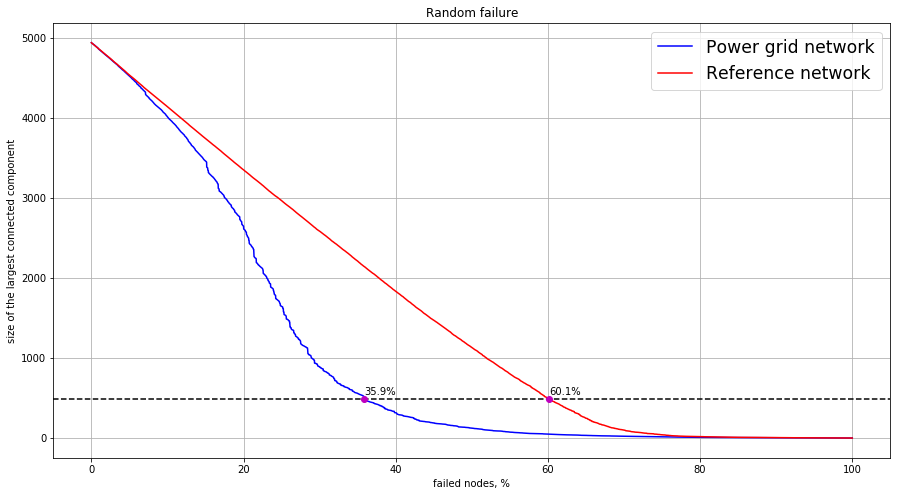

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Random failure")
plt.xlabel("failed nodes, %")
plt.ylabel("size of the largest connected component")
power_xs_tmp = np.arange(len(power_graph_gcc_mean_sizes_random_failure_nodes))
ref_xs_tmp = np.arange(len(ref_graph_gcc_mean_sizes_random_failure_nodes))
plt.plot(to_percent(power_xs_tmp), power_graph_gcc_mean_sizes_random_failure_nodes, 'blue', label='Power grid network')
plt.plot(to_percent(ref_xs_tmp), ref_graph_gcc_mean_sizes_random_failure_nodes, 'red', label='Reference network')
add_threshold_line()
plt.grid(True)

mark_cutoff_point(power_graph_gcc_mean_sizes_random_failure_nodes, max(power_xs_tmp))
mark_cutoff_point(ref_graph_gcc_mean_sizes_random_failure_nodes, max(ref_xs_tmp))

plt.legend(loc='upper right', fontsize='xx-large');

I - initial, R - recalculated.

For I attacks specified criteria calculated once, nodes sorted in descending order, and then removed one by one in that order.

For R attacks same, but criteria gets recalculated after each network update (removed node). 

In [22]:
power_graph_gcc_sizes_ID_attack = I_node_attack(power_graph, power_nodes_count, igraph.Graph.degree)
ref_graph_gcc_sizes_ID_attack = I_node_attack(ref_graph, ref_nodes_count, igraph.Graph.degree)
power_graph_gcc_sizes_IC_attack = I_node_attack(power_graph, power_nodes_count, igraph.Graph.closeness)
ref_graph_gcc_sizes_IC_attack = I_node_attack(ref_graph, ref_nodes_count, igraph.Graph.closeness)
power_graph_gcc_sizes_IB_attack = I_node_attack(power_graph, power_nodes_count, igraph.Graph.betweenness)
ref_graph_gcc_sizes_IB_attack = I_node_attack(ref_graph, ref_nodes_count, igraph.Graph.betweenness)

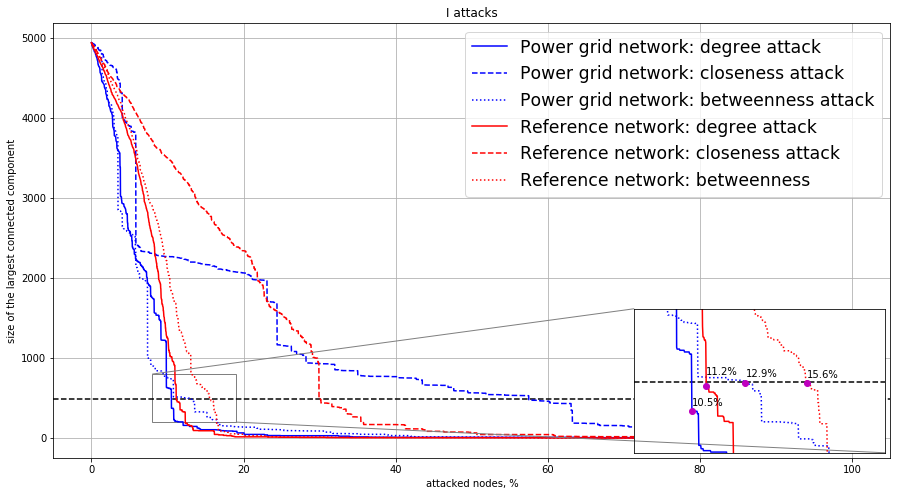

In [25]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.set_title("I attacks")
ax.set_xlabel("attacked nodes, %")
ax.set_ylabel("size of the largest connected component")

tmp_xs = np.arange(len(power_graph_gcc_sizes_ID_attack)) # shared 
tmp_xs_perc = to_percent(tmp_xs)

ax.plot(tmp_xs_perc, power_graph_gcc_sizes_ID_attack, 'blue', label='Power grid network: degree attack')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_IC_attack, 'blue', label='Power grid network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_IB_attack, 'blue', label='Power grid network: betweenness attack', linestyle='dotted')

ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_ID_attack, 'red', label='Reference network: degree attack')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_IC_attack, 'red', label='Reference network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_IB_attack, 'red', label='Reference network: betweenness', linestyle='dotted')

add_threshold_line()
ax.grid(True)
plt.legend(loc='upper right', fontsize='xx-large')

# sub region of the original image
axins = zoomed_inset_axes(ax, 3, loc='lower right')
x1, x2, y1, y2 = 8, 19, 200, 800
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.plot(tmp_xs_perc, power_graph_gcc_sizes_ID_attack, 'blue', label='Power grid network: degree attack')
axins.plot(tmp_xs_perc, power_graph_gcc_sizes_IC_attack, 'blue', label='Power grid network: closeness attack', linestyle='dashed')
axins.plot(tmp_xs_perc, power_graph_gcc_sizes_IB_attack, 'blue', label='Power grid network: betweenness attack', linestyle='dotted')

axins.plot(tmp_xs_perc, ref_graph_gcc_sizes_ID_attack, 'red', label='Reference network: degree attack')
axins.plot(tmp_xs_perc, ref_graph_gcc_sizes_IC_attack, 'red', label='Reference network: closeness attack', linestyle='dashed')
axins.plot(tmp_xs_perc, ref_graph_gcc_sizes_IB_attack, 'red', label='Reference network: betweenness', linestyle='dotted')

add_threshold_line(ax=axins)

mark_cutoff_point(power_graph_gcc_sizes_ID_attack, max(tmp_xs), y_shift=power_nodes_count//200, ax=axins)
mark_cutoff_point(power_graph_gcc_sizes_IC_attack, max(tmp_xs), ax=axins, display=False)
mark_cutoff_point(power_graph_gcc_sizes_IB_attack, max(tmp_xs), y_shift=power_nodes_count//200, ax=axins)
mark_cutoff_point(ref_graph_gcc_sizes_ID_attack, max(tmp_xs), ax=axins)
mark_cutoff_point(ref_graph_gcc_sizes_IB_attack, max(tmp_xs), ax=axins, display=False)
mark_cutoff_point(ref_graph_gcc_sizes_IB_attack, max(tmp_xs), y_shift=power_nodes_count//200, ax=axins)

plt.xticks(visible=False)
plt.yticks(visible=False)
setp(axins,xticks=[],yticks=[])

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5");

In [26]:
power_graph_gcc_sizes_RD_attack = R_node_attack(power_graph, power_nodes_count, igraph.Graph.degree)
ref_graph_gcc_sizes_RD_attack = R_node_attack(ref_graph, ref_nodes_count, igraph.Graph.degree)
power_graph_gcc_sizes_RC_attack = R_node_attack(power_graph, power_nodes_count, igraph.Graph.closeness)
ref_graph_gcc_sizes_RC_attack = R_node_attack(ref_graph, ref_nodes_count, igraph.Graph.closeness)
power_graph_gcc_sizes_RB_attack = R_node_attack(power_graph, power_nodes_count, igraph.Graph.betweenness)
ref_graph_gcc_sizes_RB_attack = R_node_attack(ref_graph, ref_nodes_count, igraph.Graph.betweenness)

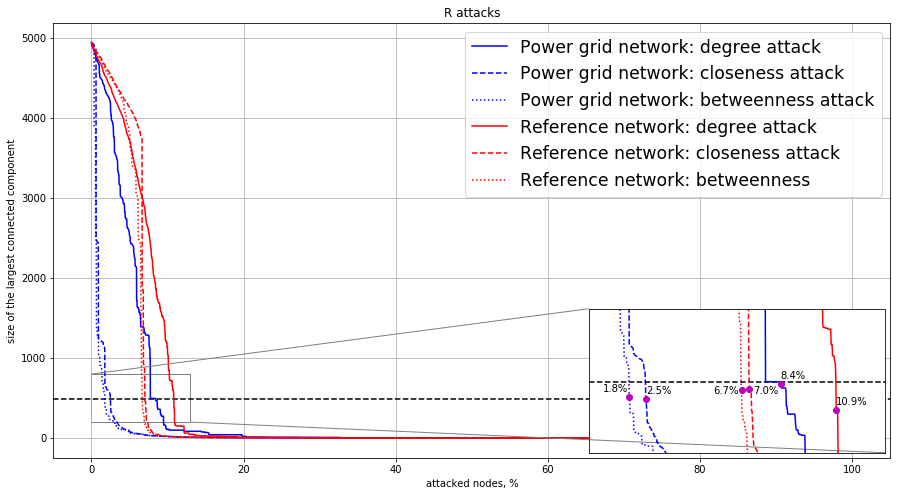

In [42]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.set_title("R attacks")
ax.set_xlabel("attacked nodes, %")
ax.set_ylabel("size of the largest connected component")

tmp_xs = np.arange(len(power_graph_gcc_sizes_RD_attack)) # shared 
tmp_xs_perc = to_percent(tmp_xs)

ax.plot(tmp_xs_perc, power_graph_gcc_sizes_RD_attack, 'blue', label='Power grid network: degree attack')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_RC_attack, 'blue', label='Power grid network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_RB_attack, 'blue', label='Power grid network: betweenness attack', linestyle='dotted')

ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_RD_attack, 'red', label='Reference network: degree attack')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_RC_attack, 'red', label='Reference network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_RB_attack, 'red', label='Reference network: betweenness', linestyle='dotted')

add_threshold_line()
ax.grid(True)

ax.legend(loc='upper right', fontsize='xx-large')

# sub region of the original image
axins = zoomed_inset_axes(ax, 3, loc='lower right')
x1, x2, y1, y2 = 0, 13, 200, 800
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.plot(tmp_xs_perc, power_graph_gcc_sizes_RD_attack, 'blue', label='Power grid network: degree attack')
axins.plot(tmp_xs_perc, power_graph_gcc_sizes_RC_attack, 'blue', label='Power grid network: closeness attack', linestyle='dashed')
axins.plot(tmp_xs_perc, power_graph_gcc_sizes_RB_attack, 'blue', label='Power grid network: betweenness attack', linestyle='dotted')

axins.plot(tmp_xs_perc, ref_graph_gcc_sizes_RD_attack, 'red', label='Reference network: degree attack')
axins.plot(tmp_xs_perc, ref_graph_gcc_sizes_RC_attack, 'red', label='Reference network: closeness attack', linestyle='dashed')
axins.plot(tmp_xs_perc, ref_graph_gcc_sizes_RB_attack, 'red', label='Reference network: betweenness', linestyle='dotted')

add_threshold_line(ax=axins)

mark_cutoff_point(power_graph_gcc_sizes_RD_attack, max(tmp_xs), y_shift=power_nodes_count//200, ax=axins)
mark_cutoff_point(power_graph_gcc_sizes_RC_attack, max(tmp_xs), y_shift=power_nodes_count//200, ax=axins)
mark_cutoff_point(power_graph_gcc_sizes_RB_attack, max(tmp_xs), y_shift=power_nodes_count//200, x_shift=-1.15, ax=axins)
mark_cutoff_point(ref_graph_gcc_sizes_RD_attack, max(tmp_xs), y_shift=power_nodes_count//200, ax=axins)
mark_cutoff_point(ref_graph_gcc_sizes_RC_attack, max(tmp_xs), y_shift=-power_nodes_count//300, x_shift=0.15, ax=axins)
mark_cutoff_point(ref_graph_gcc_sizes_RB_attack, max(tmp_xs), y_shift=-power_nodes_count//300, x_shift=-1.25, ax=axins)


plt.xticks(visible=False)
plt.yticks(visible=False)
setp(axins,xticks=[],yticks=[])

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5");

## 7.2 Edges

In [13]:
def random_failure_edges(g, edges_num):
    """Repeatedly randomly remove links from the graph and calculate size of largest connected component.
    
    Args: 
        g: igraph.Graph instance
        edges_num: int, number of links up to which "fail"
    Return:
        gcc_sizes: numpy array of integers 
    """
    g = g.copy()
    gcc_sizes = [g.vcount()]
    edges_num = min(edges_num, g.ecount())   # say no to empty list 
    for i in tqdm(range(edges_num), leave=False, desc="Failures"):
        idx = np.random.randint(g.ecount())
        g.delete_edges(idx)
        gcc_size = np.max([len(component) for component in g.components()])
        gcc_sizes.append(gcc_size)
    
    return np.array(gcc_sizes)

def node_attributes_to_edge_attributes(g, attribute_func):
    """Derive edge attributes from attributes of adjacent nodes.  
    
    Args: 
        g: igraph.Graph instance
        attribute_func: igraph.Graph function that calculates certain local graph property (e.g.: igraph.Graph.degree) 
    Return:
        edge_attributes: numpy array 
    """
    node_attributes = attribute_func(g)
    edge_attributes = np.empty(g.ecount())
    for i, edge in enumerate(g.es()):
        edge_attributes[i] = node_attributes[edge.source] + node_attributes[edge.target]
    
    return edge_attributes

def I_edge_attack(g, edges_num, attribute_func):
    """Repeatedly remove edges with highest <type> derived from adjacent nodes (based on initial(!) graph) and calculate size of largest connected component.
    
    Args: 
        g: igraph.Graph instance
        edges_num: int, number of edges up to which "attacked"
        attribute_func: igraph.Graph function that calculates certain local graph property (e.g.: igraph.Graph.degree) 
    Return:
        gcc_sizes: numpy array of integers 
    """
    g = g.copy()
    gcc_sizes = [g.vcount()]
    edges_num = min(edges_num, g.ecount()-1)   # say no to empty list
    attribute = node_attributes_to_edge_attributes(g, attribute_func)
    attribute_desc_order = attribute.argsort()[::-1]
    for i in tqdm(range(edges_num), leave=False, desc="Attack"):
        idx = attribute_desc_order[i]
        g.delete_edges(idx)
        attribute_desc_order[attribute_desc_order > idx] -= 1  # account for shift of indices in graph 
        gcc_size = np.max([len(component) for component in g.components()])
        gcc_sizes.append(gcc_size)
        
    return np.array(gcc_sizes)

def R_edge_attack(g, edges_num, attribute_func, extended_output=False):
    """Repeatedly remove edges with highest <type> derived from adjacent nodes (based on current(!) graph) and calculate size of largest connected component.
    
    Args: 
        g: igraph.Graph instance
        edges_num: int, number of edges up to which "attacked"
        attribute_func: igraph.Graph function that calculates certain local graph property (e.g.: igraph.Graph.degree)
        extended_output: bool, whether to return resulting graph and history of removed nodes
    Return:
        gcc_sizes: numpy array of integers 
    """
    g = g.copy()
    gcc_sizes = [g.vcount()]
    idx_history = []
    edges_num = min(edges_num, g.ecount()-1)   # say no to empty list
    argmax = np.nanargmax                      # avoid nan's while possible 
    for i in tqdm(range(edges_num), leave=False, desc="Attack", disable=len(range(edges_num))<10):
        try:
            idx = argmax(node_attributes_to_edge_attributes(g, attribute_func))
        except:
            argsort = np.argmax
            idx = argmax(node_attributes_to_edge_attributes(g, attribute_func))
        
        idx_history.append(idx)
        g.delete_edges(idx)
        gcc_size = np.max([len(component) for component in g.components()])
        gcc_sizes.append(gcc_size)
        
    if extended_output:
        return np.array(gcc_sizes), g, idx_history 
    else:
        return np.array(gcc_sizes)

In [ ]:
repeats = 30
power_graph_gcc_sizes_random_failure_edges = np.array([random_failure_edges(power_graph, power_nodes_count-1) for r in tqdm(range(repeats), desc="Power grid: random failures", unit="experiment", leave=False)])
ref_graph_gcc_sizes_random_failure_edges = np.array([random_failure_edges(ref_graph, ref_nodes_count-1) for r in tqdm(range(repeats), desc="Reference network: random failures", unit="experiment", leave=False)])
power_graph_gcc_mean_sizes_random_failure_edges = power_graph_gcc_sizes_random_failure_edges.mean(axis=0)
ref_graph_gcc_mean_sizes_random_failure_edges = ref_graph_gcc_sizes_random_failure_edges.mean(axis=0)

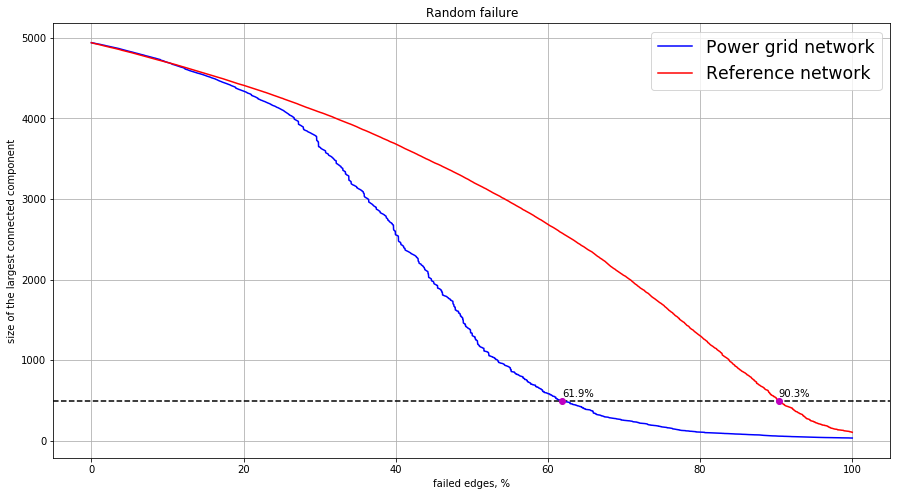

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Random failure")
plt.xlabel("failed edges, %")
plt.ylabel("size of the largest connected component")
power_xs_tmp = np.arange(len(power_graph_gcc_mean_sizes_random_failure_edges))
ref_xs_tmp = np.arange(len(ref_graph_gcc_mean_sizes_random_failure_edges))
plt.plot(to_percent(power_xs_tmp), power_graph_gcc_mean_sizes_random_failure_edges, 'blue', label='Power grid network')
plt.plot(to_percent(ref_xs_tmp), ref_graph_gcc_mean_sizes_random_failure_edges, 'red', label='Reference network')
add_threshold_line()
plt.grid(True)

mark_cutoff_point(power_graph_gcc_mean_sizes_random_failure_edges, max(power_xs_tmp))
mark_cutoff_point(ref_graph_gcc_mean_sizes_random_failure_edges, max(ref_xs_tmp))

plt.legend(loc='upper right', fontsize='xx-large');

I - initial, R - recalculated.

For I attacks specified criteria calculated once, edges sorted in descending order, and then removed one by one in that order.

For R attacks same, but criteria gets recalculated after each network update (removed edge). 

Edge criteria defined as sum of said criteria for two nodes that it connects.

In [43]:
power_graph_gcc_sizes_ID_edge_attack = I_edge_attack(power_graph, power_links_count-1, igraph.Graph.degree)
ref_graph_gcc_sizes_ID_edge_attack = I_edge_attack(ref_graph, ref_links_count-1, igraph.Graph.degree)
power_graph_gcc_sizes_IC_edge_attack = I_edge_attack(power_graph, power_links_count-1, igraph.Graph.closeness)
ref_graph_gcc_sizes_IC_edge_attack = I_edge_attack(ref_graph, ref_links_count-1, igraph.Graph.closeness)
power_graph_gcc_sizes_IB_edge_attack = I_edge_attack(power_graph, power_links_count-1, igraph.Graph.betweenness)
ref_graph_gcc_sizes_IB_edge_attack = I_edge_attack(ref_graph, ref_links_count-1, igraph.Graph.betweenness)

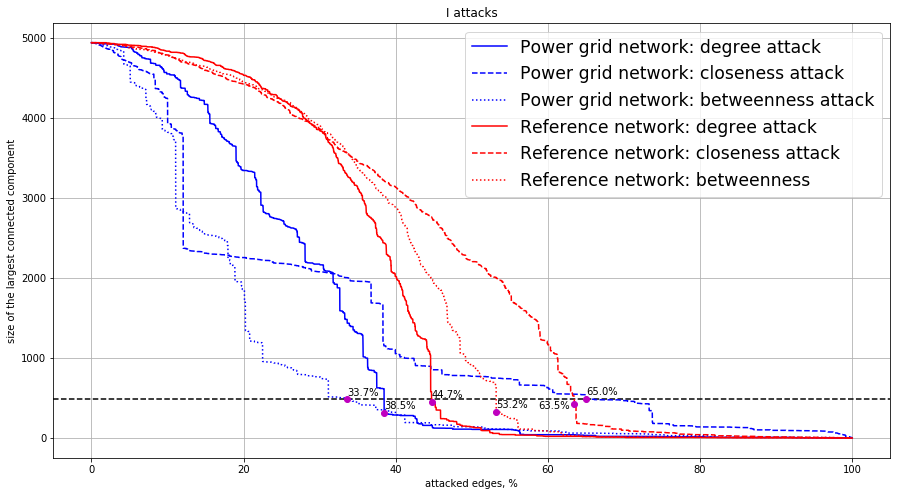

In [51]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.set_title("I attacks")
ax.set_xlabel("attacked edges, %")
ax.set_ylabel("size of the largest connected component")

tmp_xs = np.arange(len(power_graph_gcc_sizes_ID_edge_attack)) # shared 
tmp_xs_perc = to_percent(tmp_xs)

ax.plot(tmp_xs_perc, power_graph_gcc_sizes_ID_edge_attack, 'blue', label='Power grid network: degree attack')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_IC_edge_attack, 'blue', label='Power grid network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_IB_edge_attack, 'blue', label='Power grid network: betweenness attack', linestyle='dotted')

ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_ID_edge_attack, 'red', label='Reference network: degree attack')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_IC_edge_attack, 'red', label='Reference network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_IB_edge_attack, 'red', label='Reference network: betweenness', linestyle='dotted')

mark_cutoff_point(power_graph_gcc_sizes_ID_edge_attack, max(tmp_xs))
mark_cutoff_point(power_graph_gcc_sizes_IC_edge_attack, max(tmp_xs))
mark_cutoff_point(power_graph_gcc_sizes_IB_edge_attack, max(tmp_xs))
mark_cutoff_point(ref_graph_gcc_sizes_ID_edge_attack, max(tmp_xs))
mark_cutoff_point(ref_graph_gcc_sizes_IC_edge_attack, max(tmp_xs), y_shift=-power_nodes_count//80, x_shift=-4.7)
mark_cutoff_point(ref_graph_gcc_sizes_IB_edge_attack, max(tmp_xs))

add_threshold_line()
ax.grid(True)
plt.legend(loc='upper right', fontsize='xx-large');

In [52]:
power_graph_gcc_sizes_RD_edge_attack = R_edge_attack(power_graph, power_links_count-1, igraph.Graph.degree)
ref_graph_gcc_sizes_RD_edge_attack = R_edge_attack(ref_graph, ref_links_count-1, igraph.Graph.degree)
power_graph_gcc_sizes_RC_edge_attack = R_edge_attack(power_graph, power_links_count-1, igraph.Graph.closeness)
ref_graph_gcc_sizes_RC_edge_attack = R_edge_attack(ref_graph, ref_links_count-1, igraph.Graph.closeness)
power_graph_gcc_sizes_RB_edge_attack = R_edge_attack(power_graph, power_links_count-1, igraph.Graph.betweenness)
ref_graph_gcc_sizes_RB_edge_attack = R_edge_attack(ref_graph, ref_links_count-1, igraph.Graph.betweenness)

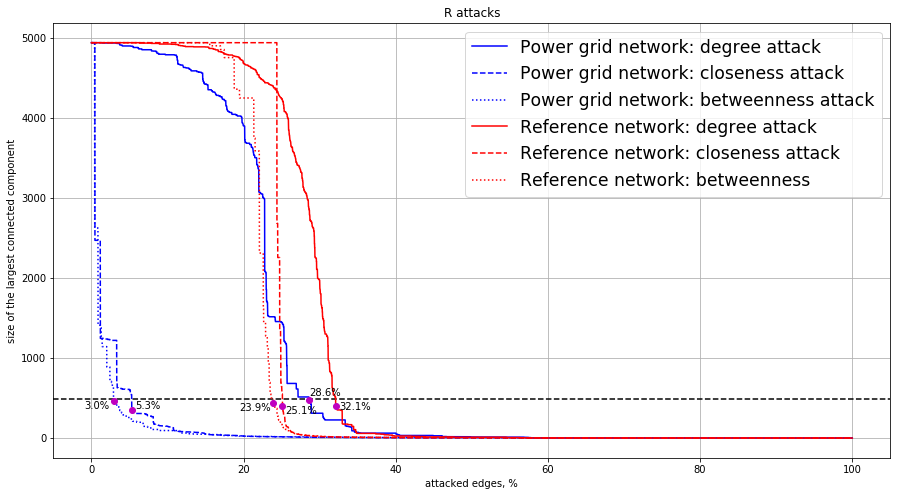

In [85]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.set_title("R attacks")
ax.set_xlabel("attacked edges, %")
ax.set_ylabel("size of the largest connected component")

tmp_xs = np.arange(len(power_graph_gcc_sizes_RD_edge_attack)) # shared 
tmp_xs_perc = to_percent(tmp_xs)

ax.plot(tmp_xs_perc, power_graph_gcc_sizes_RD_edge_attack, 'blue', label='Power grid network: degree attack')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_RC_edge_attack, 'blue', label='Power grid network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, power_graph_gcc_sizes_RB_edge_attack, 'blue', label='Power grid network: betweenness attack', linestyle='dotted')

ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_RD_edge_attack, 'red', label='Reference network: degree attack')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_RC_edge_attack, 'red', label='Reference network: closeness attack', linestyle='dashed')
ax.plot(tmp_xs_perc, ref_graph_gcc_sizes_RB_edge_attack, 'red', label='Reference network: betweenness', linestyle='dotted')

mark_cutoff_point(power_graph_gcc_sizes_RD_edge_attack, max(tmp_xs))
mark_cutoff_point(power_graph_gcc_sizes_RC_edge_attack, max(tmp_xs), y_shift=power_nodes_count//300, x_shift=0.5)
mark_cutoff_point(power_graph_gcc_sizes_RB_edge_attack, max(tmp_xs), y_shift=-power_nodes_count//50, x_shift=-4)
mark_cutoff_point(ref_graph_gcc_sizes_RD_edge_attack, max(tmp_xs), y_shift=-power_nodes_count//100, x_shift=0.5)
mark_cutoff_point(ref_graph_gcc_sizes_RC_edge_attack, max(tmp_xs), y_shift=-power_nodes_count//50, x_shift=0.4)
mark_cutoff_point(ref_graph_gcc_sizes_RB_edge_attack, max(tmp_xs), y_shift=-power_nodes_count//50, x_shift=-4.5)

add_threshold_line()
ax.grid(True)

ax.legend(loc='upper right', fontsize='xx-large');

## 7.3  Mixed

Mixed attack scheme:

1. Attack nodes (remove 1), save GCC size.
2. Attack edges (remove 1), save GCC size.
3. Compare GCC sizes after attack on nodes and attack on edges: if GCC (edge) smaller take remove-edge-graph-state; if GCC (node) smaller and step 2 has been repeated less than k times, then repeat step 2; otherwise take remove-node-graph-state
4. If process has been completed less than n times - go to step 1, otherwise - done.

Scheme basically implements greedy algorithm, where edges removal prioritized and can have several steps in depth. 

Here k = 5, n = 1000

D - degree, B - betweenness, C - closeness. 
First letter specify criteria for nodes, second for edges.

In [14]:
steps = 1000
edges_per_node = 5 

def R_mixed_attack(g, edges_per_node, steps, node_attribute_func, edge_attribute_func):
    g = g.copy()
    gcc_sizes = [g.vcount()]
    steps = np.min([g.vcount()-1, g.ecount()-1, steps])
    idx_history = []
    
    for i in tqdm(range(steps), leave=False, desc="Attack"):
        edges_attack_prevail = False
        gcc_size_node_candidate, g_node_candidate, idx_node_candidate = R_node_attack(g, 1, node_attribute_func, extended_output=True)
        gcc_size_node_candidate = gcc_size_node_candidate[-1] # assume only one iteration for now
        
        g_edge_candidate = g.copy()
        gcc_size_edge_candidates_tmp_history = []
        idx_edge_candidates_tmp_history = []
        for k in range(edges_per_node):
            if g_edge_candidate.ecount() == 0:
                break
            gcc_size_edge_candidate, g_edge_candidate, idx_edge_candidate = R_edge_attack(g_edge_candidate, 1, edge_attribute_func, extended_output=True)
            gcc_size_edge_candidate = gcc_size_edge_candidate[-1]
            idx_edge_candidate = idx_edge_candidate[-1]
            gcc_size_edge_candidates_tmp_history.append(gcc_size_edge_candidate)
            idx_edge_candidates_tmp_history.append(idx_edge_candidate)
            if gcc_size_edge_candidate < gcc_size_node_candidate:
                edges_attack_prevail = True
                break 
        
        if edges_attack_prevail:
            g = g_edge_candidate
            for gcc_size_tmp, idx_tmp in zip(gcc_size_edge_candidates_tmp_history, idx_edge_candidates_tmp_history):
                gcc_sizes.append(gcc_size_tmp)
                idx_history.append((idx_tmp, 1)) # 1 for edge
        else:
            g = g_node_candidate
            gcc_sizes.append(gcc_size_node_candidate)
            idx_history.append((idx_node_candidate[0], 0)) # 0 for node
    
    return np.array(gcc_sizes), g, idx_history

In [17]:
power_graph_gcc_sizes_RBB_mixed_attack, power_damaged_graph_RBB_mixed_attack, power_graph_idx_history_RBB_mixed_attack = R_mixed_attack(power_graph, edges_per_node, steps, igraph.Graph.betweenness, igraph.Graph.betweenness)
power_graph_gcc_sizes_RBD_mixed_attack, power_damaged_graph_RBD_mixed_attack, power_graph_idx_history_RBD_mixed_attack = R_mixed_attack(power_graph, edges_per_node, steps, igraph.Graph.betweenness, igraph.Graph.degree)
power_graph_gcc_sizes_RBC_mixed_attack, power_damaged_graph_RBC_mixed_attack, power_graph_idx_history_RBC_mixed_attack = R_mixed_attack(power_graph, edges_per_node, steps, igraph.Graph.betweenness, igraph.Graph.closeness)
power_graph_gcc_sizes_RBB_mixed_attack = power_graph_gcc_sizes_RBB_mixed_attack[:steps]
power_graph_gcc_sizes_RBD_mixed_attack = power_graph_gcc_sizes_RBD_mixed_attack[:steps]
power_graph_gcc_sizes_RBC_mixed_attack = power_graph_gcc_sizes_RBC_mixed_attack[:steps]

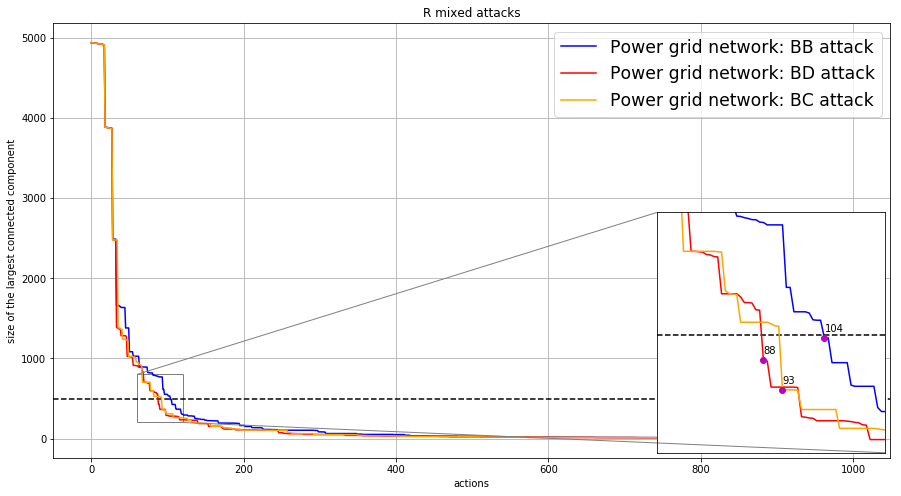

In [21]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.set_title("R mixed attacks")
ax.set_xlabel("actions")
ax.set_ylabel("size of the largest connected component")
tmp_xs = range(steps) 
ax.plot(tmp_xs, power_graph_gcc_sizes_RBB_mixed_attack, 'blue', label='Power grid network: BB attack')
ax.plot(tmp_xs, power_graph_gcc_sizes_RBD_mixed_attack, 'red', label='Power grid network: BD attack')
ax.plot(tmp_xs, power_graph_gcc_sizes_RBC_mixed_attack, 'orange', label='Power grid network: BC attack')

add_threshold_line()
ax.grid(True)

ax.legend(loc='upper right', fontsize='xx-large')

# sub region of the original image
axins = zoomed_inset_axes(ax, 5, loc='lower right')
x1, x2, y1, y2 = 60, 120, 200, 800
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.plot(tmp_xs, power_graph_gcc_sizes_RBB_mixed_attack, 'blue', label='Power grid network: BB attack')
axins.plot(tmp_xs, power_graph_gcc_sizes_RBD_mixed_attack, 'red', label='Power grid network: BD attack')
axins.plot(tmp_xs, power_graph_gcc_sizes_RBC_mixed_attack, 'orange', label='Power grid network: BC attack')

add_threshold_line(ax=axins)

mark_cutoff_point(power_graph_gcc_sizes_RBB_mixed_attack, 1, y_shift=power_nodes_count//300, ax=axins, normalize=False)
mark_cutoff_point(power_graph_gcc_sizes_RBD_mixed_attack, 1, y_shift=power_nodes_count//300, ax=axins, normalize=False)
mark_cutoff_point(power_graph_gcc_sizes_RBC_mixed_attack, 1, y_shift=power_nodes_count//300, ax=axins, normalize=False)

plt.xticks(visible=False)
plt.yticks(visible=False)
setp(axins,xticks=[],yticks=[])

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5");

## 7.4 Comparison 

Objectives = nodes  + edges

Squad size = nodes * 5 agents/node + edges * 1 agent/edge

Both solo nodes and solo edges rely on recalculated betweenness attack.

In [54]:
power_graph_nodes_attack_objectives, _ = find_cutoff(power_graph_gcc_sizes_RB_attack)
power_graph_nodes_attack_squad = edges_per_node * power_graph_nodes_attack_objectives


power_graph_edges_attack_objectives, _ = find_cutoff(power_graph_gcc_sizes_RB_edge_attack)
power_graph_edges_attack_squad = power_graph_edges_attack_objectives


power_graph_mixed_attack_RBB_cutoff_step, _ = find_cutoff(power_graph_gcc_sizes_RBB_mixed_attack)
power_graph_mixed_attack_RBC_cutoff_step, _ = find_cutoff(power_graph_gcc_sizes_RBC_mixed_attack)
power_graph_mixed_attack_RBB_action_type, power_graph_mixed_attack_RBB_action_type_count = np.unique(np.array(power_graph_idx_history_RBB_mixed_attack)[:power_graph_mixed_attack_RBB_cutoff_step, 1], return_counts=True)
power_graph_mixed_attack_RBC_action_type, power_graph_mixed_attack_RBC_action_type_count = np.unique(np.array(power_graph_idx_history_RBC_mixed_attack)[:power_graph_mixed_attack_RBC_cutoff_step, 1], return_counts=True)

power_graph_mixed_attack_RBB_objectives = 0
power_graph_mixed_attack_RBC_objectives = 0
power_graph_mixed_attack_RBB_squad = 0
power_graph_mixed_attack_RBC_squad = 0

for t, count in zip(power_graph_mixed_attack_RBB_action_type, power_graph_mixed_attack_RBB_action_type_count):
    power_graph_mixed_attack_RBB_objectives += count
    if t == 0:
        power_graph_mixed_attack_RBB_squad += edges_per_node * count
    else:
        power_graph_mixed_attack_RBB_squad += count
        
for t, count in zip(power_graph_mixed_attack_RBC_action_type, power_graph_mixed_attack_RBC_action_type_count):
    power_graph_mixed_attack_RBC_objectives += count
    if t == 0:
        power_graph_mixed_attack_RBC_squad += edges_per_node * count
    else:
        power_graph_mixed_attack_RBC_squad += count

In [55]:
report = [["Solo nodes", power_graph_nodes_attack_objectives, power_graph_nodes_attack_squad], 
          ["Solo edges", power_graph_edges_attack_objectives, power_graph_edges_attack_squad],
          ["Mixed RBB", power_graph_mixed_attack_RBB_objectives, power_graph_mixed_attack_RBB_squad], 
          ["Mixed RBC", power_graph_mixed_attack_RBC_objectives, power_graph_mixed_attack_RBC_squad]]
print(tabulate(report, headers=("Type", "Number of objectives", "Squad size")))

Type          Number of objectives    Squad size
----------  ----------------------  ------------
Solo nodes                      88           440
Solo edges                     200           200
Mixed RBB                      104           332
Mixed RBC                       93           449


# 8. Visualization

To clean-up visuals, I reduce graphs by taking away branches. I call node a branch node if there is no cycle possible through it. Assumption: branches do not contain core information about the network and thus only act as noise. 

In [56]:
def strip_branches(g):
    g = g.copy()
    b = np.array(g.betweenness())
    b = 10*b/max(b)
    d = np.array(g.degree())
    while np.any(d==1):
        discard = np.where(d==1)[0]
        g.delete_vertices(discard)
        b = np.delete(b, discard)
        d = np.array(g.degree())
    
    return g, b 

In [57]:
power_graph_branchless, power_graph_branchless_vertex_sizes = strip_branches(power_graph)
ref_graph_branchless, ref_graph_branchless_vertex_sizes = strip_branches(ref_graph)

In [58]:
print(tabulate([["Power grid:", power_graph.vcount(), power_graph.ecount()], ["Power grid (branchless):", power_graph_branchless.vcount(), power_graph_branchless.ecount()], ["Reference graph:", ref_graph.vcount(), ref_graph.ecount()], ["Reference graph (branchless):", ref_graph_branchless.vcount(), ref_graph_branchless.ecount()]], headers=["Graph", "Nodes", "Edges"]))

Graph                            Nodes    Edges
-----------------------------  -------  -------
Power grid:                       4941     6594
Power grid (branchless):          3353     5006
Reference graph:                  4941     6594
Reference graph (branchless):     2770     4423


### Power grid network (branchless): Tree layout 

Here and further: size of nodes is defined by betweenness.

In [59]:
layout = power_graph_branchless.layout("tree")
igraph.plot(power_graph_branchless, layout=layout, vertex_size=power_graph_branchless_vertex_sizes)

### Reference network (branchless): Tree layout 

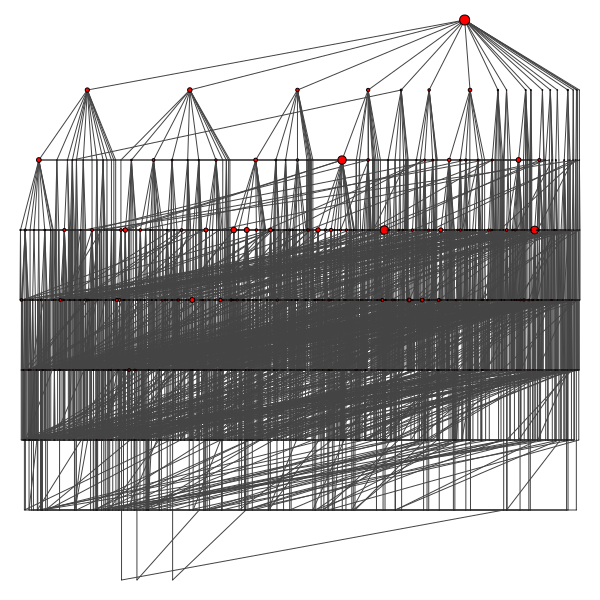

In [61]:
layout = ref_graph_branchless.layout("tree")
igraph.plot(ref_graph_branchless, layout=layout, vertex_size=ref_graph_branchless_vertex_sizes)

### Power grid network (branchless): Fruchterman-Reingold layout 

In [60]:
layout = power_graph_branchless.layout("fr")
igraph.plot(power_graph_branchless, layout=layout, vertex_size=power_graph_branchless_vertex_sizes)

### Reference network (branchless): Fruchterman-Reingold layout 

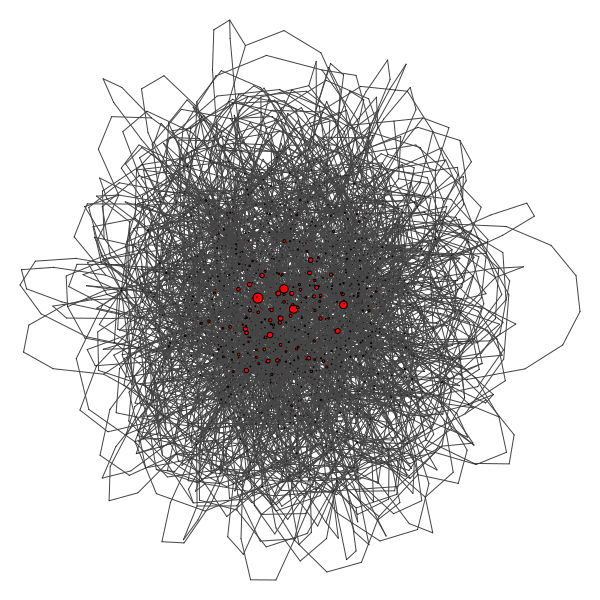

In [62]:
layout = ref_graph_branchless.layout("fr")
igraph.plot(ref_graph_branchless, layout=layout, vertex_size=ref_graph_branchless_vertex_sizes)

**Conclusion**:
Graphs examplify that Power grid has tree-like strture mostly with local connectivity, while reference network tends to long range skip-connections.

# 9. Summary

Overall, even though destruction threshold has been chosen quite arbitrary at level of 10%, it is low enough to conclude that power grid network is quite susceptible to directed attacks, including risk-averse ones (attacks on edges). Same stays true for reference network if we account for infeasible geographically links.

Based on achieved results, attack on nodes or edges with highest recalculated betweenness works the best for respective objective (1.8% and 3.0% of total number respectively). Mixed attacks balance out between nodes and edges, but does not outperform one-type attacks in number of objectives, neither in proxy metric of squad size. 

Later may be a sign of limited capacity of greedy search as it is implemented, or a weak compatibility between the metrics used for nodes and edges. Investigation of other combintions may reveal more effective attacks. 